## Random Forest for West Nile Virus
#### This model currently uses weather data only and no socio-economic features

In [47]:
#Importing all the necessary packages
import time
import itertools
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [48]:
#Reading the dataset and identify the anamolies

wnv = pd.read_csv('wnv_aggr_final.csv')
print("Shape of WNV dataset:\t", wnv.shape, "\n")
print("WNV data is present for years:\t", wnv.YEAR.unique(), "\n")
print("Number of urban counties:\t", len(wnv.GEOID10.unique()), "\n")
print("DeG12 Regions:\t", wnv.DeG12Region.unique(), "\n")
print("County WNV Class:\t", wnv.County_WNV_Class.unique(), "\n")
print("County WNV Class 2:\t", wnv.County_WNV_Class2.unique(), "\n")
print("Climate zones:\t", wnv.CLIMATE_ZONE.unique(), "\n")
wnv.head()

Shape of WNV dataset:	 (14484, 18) 

WNV data is present for years:	 [1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015] 

Number of urban counties:	 852 

DeG12 Regions:	 [2 3 6 4 5 1] 

County WNV Class:	 [2 4 1 3] 

County WNV Class 2:	 ['NI-S' 'NI-M-pre12' 'NI-S-NNI' 'none' 'NNI-S' 'NI-M-Rec' 'NNI-M'] 

Climate zones:	 ['se' 'sw' 's' 'w' 'ne' nan 'nw' 'c' 'enc' 'wnc'] 



,YEAR,GEOID10,CTYNAME,STUSPS,DeG12Region,Total_BG.sBG,County_WNV_Class,County_WNV_Class2,POPESTIMATE,NI_,NNI_,NI_IR_,Establish_,NIIR_Z,TEMPERATURE,HUMIDITY,PRECIPITATION,CLIMATE_ZONE
0,1999,1001,Autauga County,AL,2,15,2,NI-S,42963,0,0,0.000000,0,0,291.518659,73.042486,3.560286,se
1,1999,1003,Baldwin County,AL,2,28,4,NI-M-pre12,137555,0,0,0.000000,0,0,294.361160,75.947582,3.225454,se
2,1999,1015,Calhoun County,AL,2,45,2,NI-S-NNI,114910,0,0,0.000000,0,0,290.075280,72.004987,3.033717,se
3,1999,1033,Colbert County,AL,2,24,1,none,54715,0,0,0.000000,0,0,290.192782,72.069193,2.872019,se
4,1999,1045,Dale County,AL,2,10,2,NI-S-NNI,49118,0,0,0.000000,0,0,292.766317,72.045064,3.138175,se


In [49]:
wnv.describe()

,YEAR,GEOID10,DeG12Region,Total_BG.sBG,County_WNV_Class,NI_,NNI_,NI_IR_,Establish_,TEMPERATURE,HUMIDITY,PRECIPITATION
count,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000,14484.000000
mean,2007.000000,30610.929577,2.149061,170.551643,3.062207,1.106117,0.974731,0.325877,0.503383,287.580135,72.481111,2.698700
std,4.899149,15726.546563,1.625871,370.107059,1.235143,7.372081,8.664900,1.370829,0.500006,4.736292,9.610306,0.887724
min,1999.000000,1001.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,276.570013,25.241331,0.077064
25%,2003.000000,17166.000000,1.000000,26.750000,2.000000,0.000000,0.000000,0.000000,0.000000,283.882408,71.005503,2.245015
50%,2007.000000,34002.000000,1.000000,57.000000,4.000000,0.000000,0.000000,0.000000,1.000000,286.789063,75.431808,2.765165
75%,2011.000000,45022.000000,2.000000,160.000000,4.000000,0.000000,0.000000,0.000000,1.000000,290.720535,78.164789,3.226864
max,2015.000000,56025.000000,6.000000,6323.000000,4.000000,398.000000,483.000000,56.497716,1.000000,300.861155,84.850948,6.036777


### Data Preparation

In [50]:
# Stripping spaces from column names and converting into small case
wnv.columns = wnv.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [51]:
#Checking which columns have NULL values
wnv.isnull().any()

year                 False
geoid10              False
ctyname              False
stusps               False
deg12region          False
total_bg.sbg         False
county_wnv_class     False
county_wnv_class2    False
popestimate          False
ni_                  False
nni_                 False
ni_ir_               False
establish_           False
niir_z               False
temperature          False
humidity             False
precipitation        False
climate_zone          True
dtype: bool

#### Column climate_zone has "nan" values

In [52]:
df1 = wnv[wnv.isna().any(axis=1)] #Temporary dataframe to see the rows with NULL values
df1

,year,geoid10,ctyname,stusps,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
101,1999,11001,District of Columbia,DC,1,450,4,NI-M-pre12,570213,0,0,0.000000,0,0,287.240354,74.682547,3.048303,NaN
953,2000,11001,District of Columbia,DC,1,450,4,NI-M-pre12,572046,0,0,0.000000,0,,286.232539,77.070129,2.886297,NaN
1805,2001,11001,District of Columbia,DC,1,450,4,NI-M-pre12,574504,0,0,0.000000,0,,287.008458,75.081392,2.428182,NaN
2657,2002,11001,District of Columbia,DC,1,450,4,NI-M-pre12,573158,14,20,2.442607,0,,288.398005,73.538318,2.631136,NaN
3509,2003,11001,District of Columbia,DC,1,450,4,NI-M-pre12,568502,3,0,0.527703,1,-.304104453458105,286.338562,81.694270,4.287578,NaN
4361,2004,11001,District of Columbia,DC,1,450,4,NI-M-pre12,567754,1,1,0.176133,1,-.164562514192715,287.132629,79.318918,2.931562,NaN
5213,2005,11001,District of Columbia,DC,1,450,4,NI-M-pre12,567136,3,2,0.528974,1,-.159820375470469,287.162097,77.909184,2.987397,NaN
6065,2006,11001,District of Columbia,DC,1,450,4,NI-M-pre12,570681,0,2,0.000000,1,-.315771436635051,287.804769,75.949749,2.969218,NaN
6917,2007,11001,District of Columbia,DC,1,450,4,NI-M-pre12,574404,0,0,0.000000,1,-.270752103224338,288.279836,73.637152,2.295550,NaN
7769,2008,11001,District of Columbia,DC,1,450,4,NI-M-pre12,580236,4,4,0.689375,1,.118545781927193,287.334412,75.401661,3.093112,NaN


#### Assigning the climate zone - north east (ne) to DC manually based on its location

In [53]:
#Assigning the climate zone - north east (ne) to DC
wnv = wnv.fillna('ne')
wnv.climate_zone.isnull().any()

False

In [54]:
#Dropping Cityname and Statename
wnv = wnv.drop(['ctyname', 'stusps'], axis=1)

In [55]:
print(wnv.dtypes, "\n")

#Convertic the following columns to numeric type
numeric_cols = ['year', 'geoid10', 'deg12region', 'total_bg.sbg',
       'county_wnv_class', 'popestimate', 'ni_', 'nni_',
       'ni_ir_', 'establish_', 'niir_z', 'temperature', 'humidity',
       'precipitation']

wnv[numeric_cols] = wnv[numeric_cols].apply(pd.to_numeric, errors='coerce')

year                   int64
geoid10                int64
deg12region            int64
total_bg.sbg           int64
county_wnv_class       int64
county_wnv_class2     object
popestimate           object
ni_                    int64
nni_                   int64
ni_ir_               float64
establish_             int64
niir_z                object
temperature          float64
humidity             float64
precipitation        float64
climate_zone          object
dtype: object 



In [56]:
#New data types of the columns
print(wnv.dtypes, "\n")

year                   int64
geoid10                int64
deg12region            int64
total_bg.sbg           int64
county_wnv_class       int64
county_wnv_class2     object
popestimate          float64
ni_                    int64
nni_                   int64
ni_ir_               float64
establish_             int64
niir_z               float64
temperature          float64
humidity             float64
precipitation        float64
climate_zone          object
dtype: object 



In [57]:
#Checking again if the conversion introduced any null values 
df2 = wnv[wnv.isna().any(axis=1)]
df2.head(5)

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
81,1999,8014,6,42,4,NI-M-pre12,nan,0,0,0.000000,0,0.000000,283.095566,47.371319,1.537346,sw
852,2000,1001,2,15,2,NI-S,44021.000000,0,0,0.000000,0,nan,292.016556,68.767568,2.709550,se
853,2000,1003,2,28,4,NI-M-pre12,141342.000000,0,0,0.000000,0,nan,294.992369,73.640684,2.507449,se
854,2000,1015,2,45,2,NI-S-NNI,111081.000000,0,0,0.000000,0,nan,291.116250,66.668711,2.274747,se
855,2000,1033,2,24,1,none,54997.000000,0,0,0.000000,0,nan,290.819087,67.699906,2.730965,se


In [58]:
df2[df2['geoid10'] == 8014]

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
81,1999,8014,6,42,4,NI-M-pre12,nan,0,0,0.000000,0,0.000000,283.095566,47.371319,1.537346,sw
933,2000,8014,6,42,4,NI-M-pre12,39679.000000,0,0,0.000000,0,nan,284.444743,45.383618,1.153143,sw
1785,2001,8014,6,42,4,NI-M-pre12,41055.000000,0,0,0.000000,0,nan,284.201459,46.563717,1.259485,sw
2637,2002,8014,6,42,4,NI-M-pre12,41800.000000,0,0,0.000000,0,nan,283.837931,43.302272,0.860233,sw
3489,2003,8014,6,42,4,NI-M-pre12,43805.000000,11,44,25.111289,0,nan,283.656171,45.963996,1.235669,sw


#### Checked the population of Broomfield county for 1999 is 38,193

In [59]:
#Filling NaN population estimate with a value
#df2['popestimate'] = df2['popestimate'].fillna(38193)

wnv['popestimate'] = wnv['popestimate'].fillna(38193)

#### Checking again if the conversion introduced any null values 

In [60]:
df3 = wnv[wnv.isna().any(axis=1)]
df3

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone
852,2000,1001,2,15,2,NI-S,44021.000000,0,0,0.000000,0,nan,292.016556,68.767568,2.709550,se
853,2000,1003,2,28,4,NI-M-pre12,141342.000000,0,0,0.000000,0,nan,294.992369,73.640684,2.507449,se
854,2000,1015,2,45,2,NI-S-NNI,111081.000000,0,0,0.000000,0,nan,291.116250,66.668711,2.274747,se
855,2000,1033,2,24,1,none,54997.000000,0,0,0.000000,0,nan,290.819087,67.699906,2.730965,se
856,2000,1045,2,10,2,NI-S-NNI,49124.000000,0,0,0.000000,0,nan,293.179896,68.683388,2.566736,se
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14459,2015,54099,1,11,1,none,40974.000000,0,0,0.000000,0,nan,287.530721,74.973650,2.982937,c
14465,2015,55031,1,23,1,NNI-S,43623.000000,0,0,0.000000,0,nan,280.334854,77.098994,2.211064,enc
14477,2015,55117,1,37,1,NNI-S,115591.000000,0,0,0.000000,0,nan,282.297630,77.625385,1.902328,enc
14479,2015,55131,1,39,1,NNI-M,133815.000000,0,0,0.000000,0,nan,282.173286,76.072870,2.252988,enc


In [61]:
#Filling all missing values in 'niir_z' column with 0
wnv['niir_z'] = wnv['niir_z'].fillna(0)

In [62]:
#Checking if any rows have null data
wnv[wnv.isna().any(axis=1)]

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,county_wnv_class2,popestimate,ni_,nni_,ni_ir_,establish_,niir_z,temperature,humidity,precipitation,climate_zone


#### One-hot encoding categorical variables

In [63]:
# One-hot encode the data using pandas get_dummies
wnv_one = pd.get_dummies(wnv)
wnv_one.head(5)

,year,geoid10,deg12region,total_bg.sbg,county_wnv_class,popestimate,ni_,nni_,ni_ir_,establish_,...,county_wnv_class2_none,climate_zone_c,climate_zone_enc,climate_zone_ne,climate_zone_nw,climate_zone_s,climate_zone_se,climate_zone_sw,climate_zone_w,climate_zone_wnc
0,1999,1001,2,15,2,42963.000000,0,0,0.000000,0,...,0,0,0,0,0,0,1,0,0,0
1,1999,1003,2,28,4,137555.000000,0,0,0.000000,0,...,0,0,0,0,0,0,1,0,0,0
2,1999,1015,2,45,2,114910.000000,0,0,0.000000,0,...,0,0,0,0,0,0,1,0,0,0
3,1999,1033,2,24,1,54715.000000,0,0,0.000000,0,...,1,0,0,0,0,0,1,0,0,0
4,1999,1045,2,10,2,49118.000000,0,0,0.000000,0,...,0,0,0,0,0,0,1,0,0,0


In [64]:
wnv_one.columns

Index(['year', 'geoid10', 'deg12region', 'total_bg.sbg', 'county_wnv_class',
       'popestimate', 'ni_', 'nni_', 'ni_ir_', 'establish_', 'niir_z',
       'temperature', 'humidity', 'precipitation',
       'county_wnv_class2_NI-M-Rec', 'county_wnv_class2_NI-M-pre12',
       'county_wnv_class2_NI-S', 'county_wnv_class2_NI-S-NNI',
       'county_wnv_class2_NNI-M', 'county_wnv_class2_NNI-S',
       'county_wnv_class2_none', 'climate_zone_c', 'climate_zone_enc',
       'climate_zone_ne', 'climate_zone_nw', 'climate_zone_s',
       'climate_zone_se', 'climate_zone_sw', 'climate_zone_w',
       'climate_zone_wnc'],
      dtype='object')

#### Splitting data into features and labels

In [65]:
# Labels are the values we want to predict
labels = np.array(wnv_one['ni_ir_'])

In [66]:
# Remove the labels from the features
# axis 1 refers to the columns
features = wnv_one.drop('ni_ir_', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
print("Feature list:\n\n", feature_list)

Feature list:

 ['year', 'geoid10', 'deg12region', 'total_bg.sbg', 'county_wnv_class', 'popestimate', 'ni_', 'nni_', 'establish_', 'niir_z', 'temperature', 'humidity', 'precipitation', 'county_wnv_class2_NI-M-Rec', 'county_wnv_class2_NI-M-pre12', 'county_wnv_class2_NI-S', 'county_wnv_class2_NI-S-NNI', 'county_wnv_class2_NNI-M', 'county_wnv_class2_NNI-S', 'county_wnv_class2_none', 'climate_zone_c', 'climate_zone_enc', 'climate_zone_ne', 'climate_zone_nw', 'climate_zone_s', 'climate_zone_se', 'climate_zone_sw', 'climate_zone_w', 'climate_zone_wnc']


In [67]:
# Convert dataframe to numpy array
features = np.array(features)
print("The shape of features is:\t", features.shape)

The shape of features is:	 (14484, 29)


#### Splitting data into training and testing sets

In [68]:
#Setting the random state to 42 which means the results will be the same each time we run the split 
#for reproducible results

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [69]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (10863, 29)
Training Labels Shape: (10863,)
Testing Features Shape: (3621, 29)
Testing Labels Shape: (3621,)


#### RF Model

In [70]:
#Instantiating model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [71]:
start = time.process_time() #To calculate the time taken to train the model

# Train the model on training data
rf.fit(train_features, train_labels)

print("Model trained in ", time.process_time() - start, "seconds")

Model trained in  40.714470000000006 seconds


In [72]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

#### Checking the feature importance

In [73]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = feature_list,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [74]:
pd.options.display.float_format = '{:.6f}'.format
feature_importances

,importance
ni_,0.448013
popestimate,0.276161
nni_,0.159213
niir_z,0.051905
total_bg.sbg,0.021513
year,0.008826
humidity,0.007751
temperature,0.006368
precipitation,0.005863
geoid10,0.005017


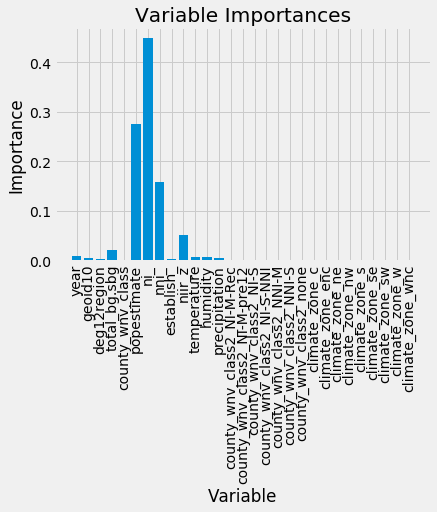

In [75]:
importances = list(rf.feature_importances_)

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Checking model performance:

In [76]:
# Calculate the absolute errors
errors = abs(predictions - test_labels)

In [77]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'IR units')

Mean Absolute Error: 0.04 IR units


In [78]:
print('R2 value: ', r2_score(test_labels, predictions))

R2 value:  0.8857593059655094


In [79]:
print ('Mean Squared Error: ', mean_squared_error(test_labels, predictions))

Mean Squared Error:  0.2502310768119116


In [80]:
# Calculate mean absolute percentage error (MAPE)
np.seterr(divide='ignore', invalid='ignore')
mape = 100 * (errors / test_labels)

In [81]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
#accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.22 %.


In [82]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]

In [83]:
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

In [84]:
# Write graph to a png file
graph.write_png('tree.png')

Model 2: Creating one more model with only 3 levels to generate a smaller image for understanding

In [85]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

Model 3: Creating another random forest with only the two most important variables

In [86]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('ni_'), feature_list.index('popestimate')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'IR units.')

Mean Absolute Error: 0.03 IR units.


In [87]:
np.seterr(divide='ignore', invalid='ignore')
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape[np.isfinite(mape)])
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 97.7 %.
